In [1]:
import sys
import os

# Import our backtester package
sys.path.append(os.path.abspath('../../'))
from backtester import get_price_data, get_vwap
print("Using backtester package")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try to import seaborn, but don't fail if it's not available
try:
    import seaborn as sns
    print(f"Seaborn version: {sns.__version__}")
    sns.set(style="whitegrid")
    HAS_SEABORN = True
except ImportError:
    print("Seaborn not available, using matplotlib instead")
    HAS_SEABORN = False

Using backtester package
Seaborn version: 0.13.2


In [2]:
# Load data directly using backtester package
print("Loading price data...")
prices = get_price_data('SQUID_INK', 1)
print(f"Loaded {len(prices)} price data points")

# Limit to first 20,000 timestamps (in-sample data)
in_sample_prices = prices.iloc[:20000]
print(f"Limited to {len(in_sample_prices)} in-sample data points")

# Get VWAP
print("Getting VWAP for SQUID_INK...")
squid_vwap = in_sample_prices['vwap']
print(f"Got VWAP with {len(squid_vwap)} data points")
print(f"VWAP range: {squid_vwap.min()} to {squid_vwap.max()}")

# Calculate log prices
log_prices = np.log(squid_vwap)
print(f"Calculated log prices with {len(log_prices)} data points")

# Calculate returns
returns = squid_vwap.pct_change().dropna()
print(f"Calculated returns with {len(returns)} data points")

Loading price data...
Loading real data for SQUID_INK from round 1...
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_-2.csv
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_0.csv
Successfully loaded real data with 30000 rows
Loaded 30000 price data points
Limited to 20000 in-sample data points
Getting VWAP for SQUID_INK...
Got VWAP with 20000 data points
VWAP range: 1832.0 to 2187.3880597014927
Calculated log prices with 20000 data points
Calculated returns with 19999 data points


Calculated CMMA with lookback 10
Calculated CMMA with lookback 20
Calculated CMMA with lookback 50


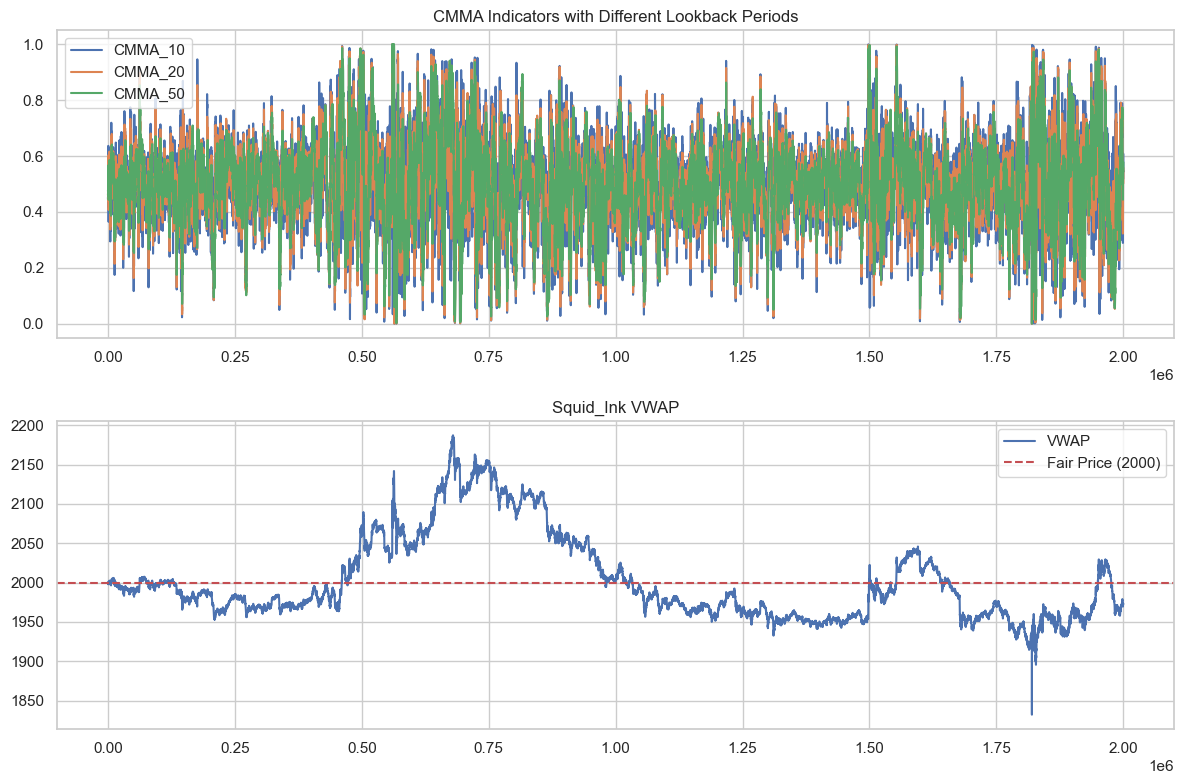

In [4]:
def calculate_cmma_log(log_prices, lookback=10):
    """
    Compute the Cumulative Moving Average Momentum (CMMA) using log prices.
    
    Parameters:
        log_prices (pd.Series): Series of log prices
        lookback (int): Lookback period
        
    Returns:
        pd.Series: CMMA indicator (0-1 range)
    """
    # Calculate raw CMMA using log prices
    raw_cmma = (log_prices - log_prices.ewm(span=lookback).mean().shift(1)).divide(np.sqrt(lookback+1)).dropna()
    
    # Normalize using sigmoid function
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    cmma = sigmoid(raw_cmma)
    return cmma

# Calculate CMMA with different lookback periods
lookback_periods = [10, 20, 50]
cmma_indicators = {}

for lookback in lookback_periods:
    cmma_indicators[f'CMMA_{lookback}'] = calculate_cmma_log(squid_vwap, lookback)
    print(f'Calculated CMMA with lookback {lookback}')

# Plot CMMA indicators
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
for lookback in lookback_periods:
    plt.plot(cmma_indicators[f'CMMA_{lookback}'], label=f'CMMA_{lookback}')
plt.title('CMMA Indicators with Different Lookback Periods')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(squid_vwap, label='VWAP')
plt.axhline(y=2000, color='r', linestyle='--', label='Fair Price (2000)')
plt.title('Squid_Ink VWAP')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
def calculate_exponential_position(price, cmma, fair_price=2000, price_range=200, exponent=2.0, max_position=1.0):
    """
    Calculate position size that scales exponentially based on CMMA indicator value.
    When CMMA is high (> 0.5), take short positions.
    When CMMA is low (< 0.5), take long positions.
    
    Parameters:
        price (float): Current price (not used in calculation, kept for interface consistency)
        cmma (float): CMMA indicator value (between 0 and 1)
        fair_price (float): Not used, kept for interface consistency
        price_range (float): Not used, kept for interface consistency
        exponent (float): Exponent for scaling (higher = more aggressive exponential growth)
        max_position (float): Maximum position size (absolute value)
        
    Returns:
        float: Position size between -max_position and max_position
    """
    # Center CMMA around 0.5 and scale to [-1, 1]
    cmma_scaled = 2 * (cmma - 0.5)
    
    # Calculate position size using exponential scaling
    if cmma_scaled > 0:
        # High CMMA -> short position
        position = -min(abs(cmma_scaled) ** exponent, 1.0) * max_position
    else:
        # Low CMMA -> long position
        position = min(abs(cmma_scaled) ** exponent, 1.0) * max_position
    
    return position

In [6]:
def cmma_dynamic_position_strategy(prices, cmma, fair_price, upper_threshold=0.7, lower_threshold=0.3, 
                                  price_range=200, exponent=2.0, max_position=1.0, update_frequency=1):
    positions = pd.Series(0.0, index=prices.index)
    valid_indices = cmma.dropna().index
    last_update_idx = -update_frequency  # Start with immediate update
    current_position = 0.0
    for time in valid_indices:
        current_price = prices.loc[time]
        current_cmma = cmma.loc[time]
        idx = prices.index.get_loc(time)
        if idx - last_update_idx >= update_frequency:
            if current_price > fair_price and current_cmma > upper_threshold:
                current_position = calculate_exponential_position(
                    current_price, current_cmma, fair_price, exponent, max_position
                )
                current_position = min(current_position, 0.0)
            elif current_price < fair_price and current_cmma < lower_threshold:
                current_position = calculate_exponential_position(
                    current_price, current_cmma, fair_price, exponent, max_position
                )
                current_position = max(current_position, 0.0)
            else:
                current_position = 0.0
            last_update_idx = idx
        positions.iloc[idx] = current_position
    
    return positions

In [7]:
# For comparison, let's also implement the original fixed-position strategy
def filtered_cmma_strategy(prices, cmma, fair_price, upper_threshold=0.7, lower_threshold=0.3, holding_period=10):
    """
    Implement a filtered CMMA-based mean reversion strategy with fixed position sizes.
    
    Parameters:
        prices (pd.Series): Series of prices
        cmma (pd.Series): CMMA indicator
        fair_price (float): Fair price to revert to
        upper_threshold (float): Upper threshold for CMMA
        lower_threshold (float): Lower threshold for CMMA
        holding_period (int): Number of periods to hold the position
        
    Returns:
        pd.Series: Portfolio positions (1 for long, -1 for short, 0 for no position)
    """
    positions = pd.Series(0, index=prices.index)
    valid_indices = cmma.dropna().index
    for time in valid_indices:
        current_price = prices.loc[time]
        current_cmma = cmma.loc[time]
        idx = prices.index.get_loc(time)
        if current_price > fair_price and current_cmma > upper_threshold:
            end_idx = min(idx + holding_period + 1, len(positions))
            positions.iloc[idx+1:end_idx] = -1
        elif current_price < fair_price and current_cmma < lower_threshold:
            end_idx = min(idx + holding_period + 1, len(positions))
            positions.iloc[idx+1:end_idx] = 1
    
    return positions

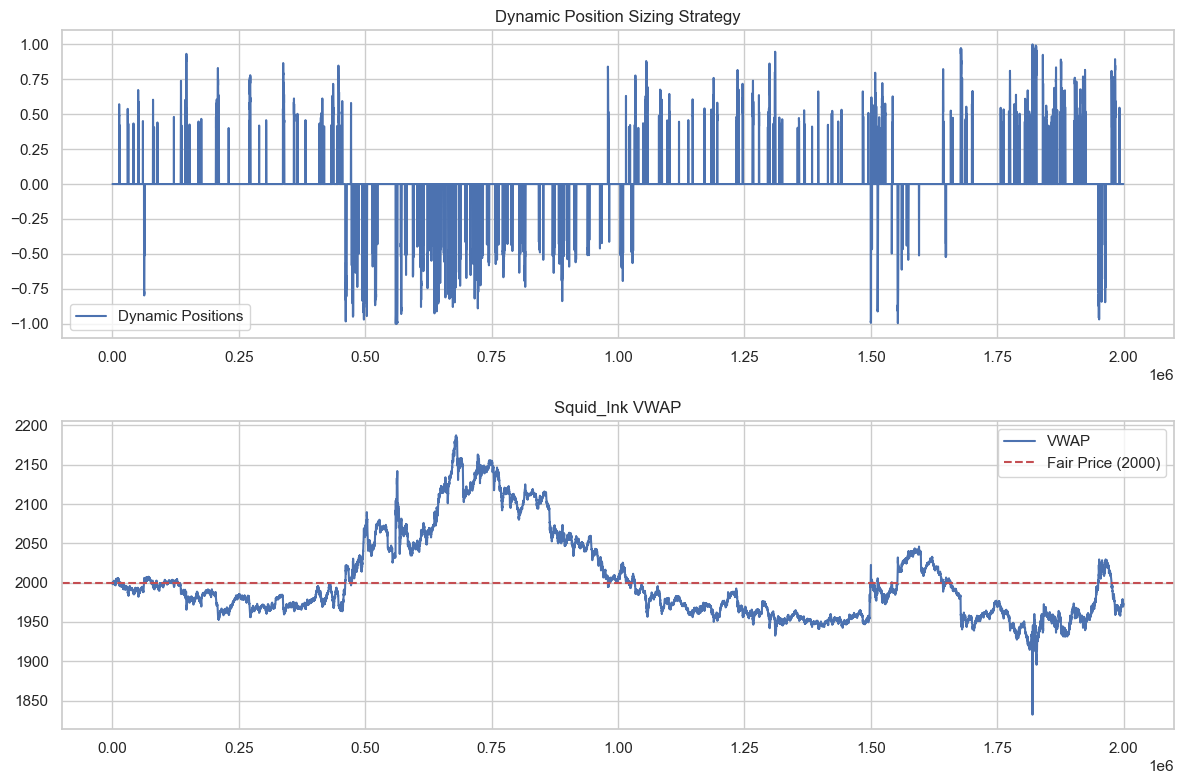

In [8]:

# Define the fair price
FAIR_PRICE = 2000

# Choose a specific lookback period for testing
lookback = 20
cmma_log = cmma_indicators[f'CMMA_{lookback}']

# Define parameters for testing
upper_threshold = 0.7  # Upper threshold for CMMA
lower_threshold = 0.3  # Lower threshold for CMMA

# Parameters for dynamic position sizing
price_range = 200      # Base price range for scaling
exponent = 2.0         # Exponent for scaling
max_position = 1.0     # Maximum position size
update_frequency = 1   # Update frequency

# Run the dynamic position strategy
dynamic_positions = cmma_dynamic_position_strategy(
    squid_vwap, cmma_log, FAIR_PRICE, upper_threshold, lower_threshold,
    price_range, exponent, max_position, update_frequency
)

# Plot the strategy positions
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(dynamic_positions, label='Dynamic Positions')
plt.title('Dynamic Position Sizing Strategy')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(squid_vwap, label='VWAP')
plt.axhline(y=FAIR_PRICE, color='r', linestyle='--', label=f'Fair Price ({FAIR_PRICE})')
plt.title('Squid_Ink VWAP')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<Axes: xlabel='timestamp'>

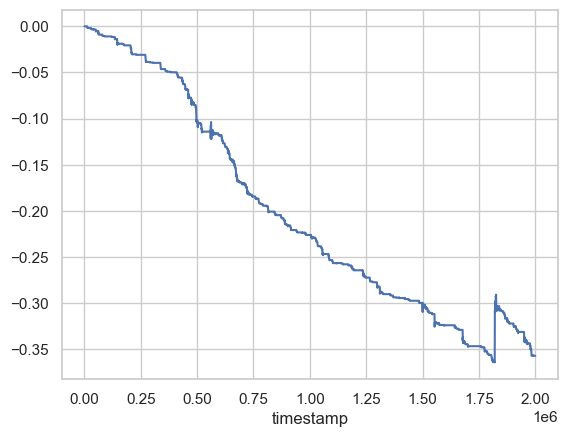

In [9]:
def calculate_returns_with_costs(positions, returns, cost_per_dollar=0.00075):
    """
    Calculate strategy returns with transaction costs.
    
    Parameters:
        positions (pd.Series): Series of positions
        returns (pd.Series): Series of price returns
        cost_per_dollar (float): Transaction cost per dollar traded (default: 0.075%)
        
    Returns:
        pd.Series: Strategy returns with transaction costs
    """
    # Calculate position changes (absolute value)
    position_changes = positions.diff().abs()
    
    # Calculate transaction costs
    transaction_costs = position_changes * cost_per_dollar
    
    # Calculate raw strategy returns
    raw_returns = positions.shift(1) * returns
    
    # Subtract transaction costs from raw returns
    net_returns = raw_returns - transaction_costs
    
    return net_returns.dropna()

# Define transaction cost (1.5/2000 = 0.075% per dollar traded)
transaction_cost = 1.5/2000  # 0.075% per dollar traded

# Calculate returns without transaction costs
raw_returns = dynamic_positions.shift(1) * returns
raw_returns = raw_returns.dropna()

# Calculate returns with transaction costs
returns_with_costs = calculate_returns_with_costs(dynamic_positions, returns, transaction_cost)
import seaborn as sns 
sns.lineplot(returns_with_costs.cumsum())


In [ ]:
# Define parameter ranges to test
price_ranges = [200]       # Base price ranges for scaling
exponents = [0, 0.5, 1.0, 1.5, 2.0, 2.5]     # Exponents for scaling
max_positions = [1.0]      # Maximum position sizes
update_frequencies = [1]      # Update frequencies

# Define CMMA threshold ranges to test
upper_thresholds = [0.6, 0.7, 0.8]  # Upper thresholds for CMMA
lower_thresholds = [0.2, 0.3, 0.4]  # Lower thresholds for CMMA

# Define transaction cost (1.5/2000 = 0.075% per dollar traded)
transaction_cost = 0  # 0.075% per dollar traded

# Initialize results dictionary
param_results = []

# Test different parameter combinations
for price_range in price_ranges:
    for exponent in exponents:
        for max_position in max_positions:
            for update_freq in update_frequencies:
                for upper_thresh in upper_thresholds:
                    for lower_thresh in lower_thresholds:
                        # Skip invalid threshold combinations (upper should be > lower)
                        if upper_thresh <= lower_thresh:
                            continue
                            
                        # Run the dynamic position strategy
                        dynamic_positions = cmma_dynamic_position_strategy(
                            squid_vwap, cmma_log, FAIR_PRICE, upper_thresh, lower_thresh,
                            price_range, exponent, max_position, update_freq
                        )
                
                        # Calculate returns with transaction costs
                        strategy_returns = calculate_returns_with_costs(dynamic_positions, returns, transaction_cost)
                        
                        # Calculate cumulative returns
                        cumulative_returns = (1 + strategy_returns).cumprod() - 1
                        
                        # Calculate performance metrics
                        total_return = strategy_returns.sum()
                        sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)  # Annualized
                        win_rate = (strategy_returns > 0).mean()
                        
                        # Count the number of trades
                        num_trades = (dynamic_positions.diff() != 0).sum()
                        
                        # Calculate total transaction costs
                        position_changes = dynamic_positions.diff().abs()
                        total_transaction_costs = (position_changes * transaction_cost).sum()
                
                        # Store results
                        param_results.append({
                            'Upper Threshold': upper_thresh,
                            'Lower Threshold': lower_thresh,
                            'Price Range': price_range,
                            'Exponent': exponent,
                            'Max Position': max_position,
                            'Update Frequency': update_freq,
                            'Total Return': total_return,
                            'Sharpe Ratio': sharpe_ratio,
                            'Win Rate': win_rate,
                            'Number of Trades': num_trades,
                            'Total Transaction Costs': total_transaction_costs
                        })
                        
                        print(f"Tested: Upper={upper_thresh:.1f}, Lower={lower_thresh:.1f}, "
                              f"Price Range={price_range}, Exponent={exponent}, "
                              f"Update Freq={update_freq}, Return={total_return:.4f}, "
                              f"Sharpe={sharpe_ratio:.4f}, Trades={num_trades}")

# Convert results to DataFrame
param_df = pd.DataFrame(param_results)

# Sort by Sharpe ratio (descending)
param_df = param_df.sort_values('Total Return', ascending=False)

# Display top 10 parameter combinations
print("\nTop 10 Parameter Combinations (sorted by Sharpe Ratio):")
display(param_df.head(10))

# Get the best parameter combination
best_params = param_df.iloc[0]

print(f"\nBest parameter combination:\n")
print(f"Upper Threshold: {best_params['Upper Threshold']:.1f}")
print(f"Lower Threshold: {best_params['Lower Threshold']:.1f}")
print(f"Price Range: {best_params['Price Range']}")
print(f"Exponent: {best_params['Exponent']}")
print(f"Max Position: {best_params['Max Position']}")
print(f"Update Frequency: {best_params['Update Frequency']}")
print(f"Total Return: {best_params['Total Return']:.4f}")
print(f"Sharpe Ratio: {best_params['Sharpe Ratio']:.4f}")
print(f"Win Rate: {best_params['Win Rate']:.4f}")
print(f"Number of Trades: {int(best_params['Number of Trades'])}")
print(f"Total Transaction Costs: {best_params['Total Transaction Costs']:.4f}")

Tested: Upper=0.6, Lower=0.2, Price Range=200, Exponent=0.5, Update Freq=1, Return=0.0578, Sharpe=0.1143, Trades=2943
Tested: Upper=0.6, Lower=0.3, Price Range=200, Exponent=0.5, Update Freq=1, Return=0.0664, Sharpe=0.1292, Trades=3730
Tested: Upper=0.6, Lower=0.4, Price Range=200, Exponent=0.5, Update Freq=1, Return=0.0829, Sharpe=0.1597, Trades=5833
Tested: Upper=0.7, Lower=0.2, Price Range=200, Exponent=0.5, Update Freq=1, Return=0.0585, Sharpe=0.1171, Trades=1540
Tested: Upper=0.7, Lower=0.3, Price Range=200, Exponent=0.5, Update Freq=1, Return=0.0671, Sharpe=0.1321, Trades=2327
Tested: Upper=0.7, Lower=0.4, Price Range=200, Exponent=0.5, Update Freq=1, Return=0.0837, Sharpe=0.1629, Trades=4430
Tested: Upper=0.8, Lower=0.2, Price Range=200, Exponent=0.5, Update Freq=1, Return=0.0581, Sharpe=0.1183, Trades=918
Tested: Upper=0.8, Lower=0.3, Price Range=200, Exponent=0.5, Update Freq=1, Return=0.0668, Sharpe=0.1335, Trades=1705
Tested: Upper=0.8, Lower=0.4, Price Range=200, Exponent=0

,Upper Threshold,Lower Threshold,Price Range,Exponent,Max Position,Update Frequency,Total Return,Sharpe Ratio,Win Rate,Number of Trades,Total Transaction Costs
77,0.7,0.4,300,2.0,1.0,1,0.083654,0.162854,0.089104,4430,0.0
86,0.7,0.4,300,2.5,1.0,1,0.083654,0.162854,0.089104,4430,0.0
68,0.7,0.4,300,1.5,1.0,1,0.083654,0.162854,0.089104,4430,0.0
5,0.7,0.4,200,0.5,1.0,1,0.083654,0.162854,0.089104,4430,0.0
14,0.7,0.4,200,1.0,1.0,1,0.083654,0.162854,0.089104,4430,0.0
59,0.7,0.4,300,1.0,1.0,1,0.083654,0.162854,0.089104,4430,0.0
23,0.7,0.4,200,1.5,1.0,1,0.083654,0.162854,0.089104,4430,0.0
50,0.7,0.4,300,0.5,1.0,1,0.083654,0.162854,0.089104,4430,0.0
32,0.7,0.4,200,2.0,1.0,1,0.083654,0.162854,0.089104,4430,0.0
41,0.7,0.4,200,2.5,1.0,1,0.083654,0.162854,0.089104,4430,0.0



Best parameter combination:

Upper Threshold: 0.7
Lower Threshold: 0.4
Price Range: 300.0
Exponent: 2.0
Max Position: 1.0
Update Frequency: 1.0
Total Return: 0.0837
Sharpe Ratio: 0.1629
Win Rate: 0.0891
Number of Trades: 4430
Total Transaction Costs: 0.0000
